In [83]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [84]:
item_20109_moq = pd.read_csv('../item_20109_moq.csv')
item_20109_moq.head()

,itemID,date,BOH,order,Replenish,Replenish_Qty,Unnamed: 6,SS,83
0,20209,7/6/2020,163,47,True,0,NaN,ROP,111.0
1,20209,14/6/2020,116,18,True,0,NaN,OU,25.0
2,20209,21/6/2020,98,33,False,75,NaN,MOQ,75.0
3,20209,28/6/2020,65,38,False,75,NaN,init,163.0
4,20209,5/7/2020,27,28,False,75,NaN,NaN,NaN


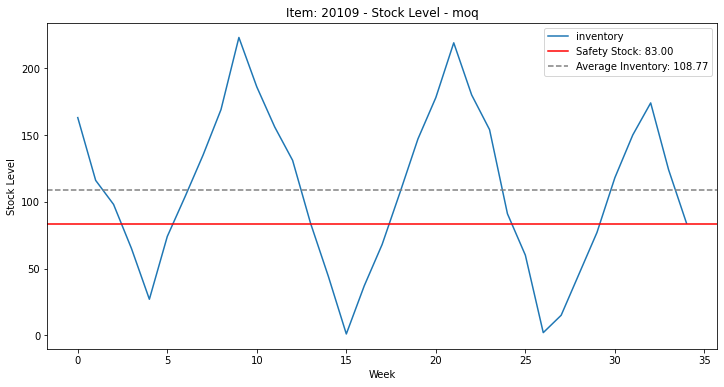

In [85]:
item_id = '20109'
safety_stock = 83
avg_inventory_level = item_20109_moq.BOH.mean()
plt.figure(figsize=(12, 6))
plt.plot(item_20109_moq.BOH, label='inventory')
plt.axhline(y=safety_stock, color='r', linestyle='-', label=f'Safety Stock: {safety_stock:.2f}')
plt.axhline(y=avg_inventory_level, color='grey', linestyle='--', label=f'Average Inventory: {avg_inventory_level:.2f}')
plt.title(f'Item: {item_id} - Stock Level - moq')
plt.xlabel('Week')
plt.ylabel('Stock Level')
plt.legend()
plt.show()

In [ ]:
df = pd.read_csv('../top78Items_aggr_weekly.csv')
df.head()
request_json_20209 = {'item_id': '20209', 'init_inventory': 163, 'min_order_qty': 75, 'lead_time': 3, 'order_unit': 25, 
                    'demand': df[df.itemID==20209].order.tolist() }

In [99]:
def smart_replenisher(request_json):
    from ortools.linear_solver import pywraplp
    # Create the MIP solver.
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # Define the input data. 
    init_inventory_level = request_json['init_inventory']
    big_M = 10000
    demand = [request_json['demand']]
    num_of_demand_scenarios = len(demand)
    num_of_weeks = len(demand[0]) 
    lead_time = request_json['lead_time']
    min_order_qty = request_json['min_order_qty']
    order_unit = request_json['order_unit']
    # TODO: introduce more constraints type & define objective function Ordering_cost+holding_cost+penalty on stockout
    ordering_cost = 20
    holding_cost = 0.2
    unit_price = 1
    service_rate = 0.99
    order_placement_interval = 3
    ss = 40
    # Define the decision variables.
    order_quantity = [solver.IntVar(0, 100, f'order_quantity_{i}') 
                        for i in range(num_of_weeks)]
    inventory_level = [[solver.IntVar(-500, 2000,  f'inventory_week{i}_scenario{j}') 
                        for i in range(num_of_weeks+1)] 
                        for j in range(num_of_demand_scenarios)]
    total_inventory_level_scenario = [solver.IntVar(-50000, solver.infinity(),  
                                                    f'exp_inventory_level_scenario{j}') 
                        for j in range(num_of_demand_scenarios)]
    stock_state  = [[solver.IntVar(0, 1, f'stock_state_week{i}_scenario{j}')
                        for i in range(num_of_weeks+1)] 
                        for j in range(num_of_demand_scenarios)]
    stock_state_sum = [solver.IntVar(0, num_of_weeks, f'stock_state_sum_scenario{j}') 
                        for j in range(num_of_demand_scenarios)]

    # Add constraint for each week's inventory level
    for j in range(num_of_demand_scenarios):
        solver.Add(inventory_level[j][0] == init_inventory_level)  # initial inventory level
        for i in range(num_of_weeks):
            if i % order_placement_interval != 0: 
                solver.Add(order_quantity[i] == 0)
            inventory_level[j][i+1] = inventory_level[j][i] - demand[j][i]
            if i >= lead_time - 1 :
                inventory_level[j][i+1] += order_quantity[i-(lead_time - 1)]*order_unit
            # add constraint to tell stock out or not
            solver.Add(inventory_level[j][i]-ss <= stock_state[j][i] * big_M )
            solver.Add(inventory_level[j][i]-ss  >= 1/big_M - (1-stock_state[j][i]) * big_M )
        stock_state_sum[j] = sum(stock_state[j])
        total_inventory_level_scenario[j] = sum(inventory_level[j])
        
    # good case
    solver.Add(sum(stock_state_sum)>=service_rate*num_of_weeks*num_of_demand_scenarios)

    # Define the objective function to minimize inventory level.
    accum_inventory_level = sum(total_inventory_level_scenario)/num_of_demand_scenarios
    holding_value = unit_price * accum_inventory_level
    total_cost = ordering_cost * 3 + holding_value + holding_cost * holding_value
    solver.Minimize(accum_inventory_level)

    # Solve the optimization problem.
    status = solver.Solve()

    # Print the optimal order quantity and total cost.
    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
        print('Optimal or Feasible solution found.')
        print('Optimal order quantity:')
        for i in range(num_of_weeks):
            print(order_quantity[i].solution_value()*order_unit,end=', ' )
        print('')
        service_rate = sum(stock_state_sum[j].solution_value() for j in range(num_of_demand_scenarios))/(num_of_weeks*num_of_demand_scenarios) 
        avg_inventory_level = sum(total_inventory_level_scenario[j].solution_value() for j in range(num_of_demand_scenarios))/(num_of_weeks*num_of_demand_scenarios)
        exp_inventory_level = []
        for i in range(num_of_weeks):
            exp_inventory_level.append(sum(inventory_level[j][i].solution_value() for j in range(num_of_demand_scenarios)))
        # return {
        #     'message': 'Optimal or Feasible solution found.',
        #     'service rate: ': service_rate,
        #     'AVG inventory level:': avg_inventory_level,
        #     'Holding Value :': holding_value.solution_value(),
        #     'Total Cost:': total_cost.solution_value(),
        # }
        print('exp inventory level:', exp_inventory_level)
        return {
            'solution_found': True,
            'replenish_required_smart': order_quantity[0].solution_value()>0,
            'suggested_qty_smart': max(order_quantity[0].solution_value()*order_unit,min_order_qty) if order_quantity[0].solution_value()>0 else 0,
            'exp_inventory_level': exp_inventory_level,
            'AVG inventory level:': avg_inventory_level,
        }
    elif  status == pywraplp.Solver.INFEASIBLE:
        return {'solution_found': False,'message': 'The problem is not feasible.'}
    elif  status == pywraplp.Solver.MODEL_INVALID:
        raise RuntimeError('The model is not valid.')
    else:
        return {'solution_found': False,
                'message': 'The problem does not have an optimal solution.'}

Optimal or Feasible solution found.
Optimal order quantity:
50.0, 0.0, 0.0, 125.0, 0.0, 0.0, 100.0, 0.0, 0.0, 100.0, 0.0, 0.0, 125.0, 0.0, 0.0, 125.0, 0.0, 0.0, 100.0, 0.0, 0.0, 150.0, 0.0, 0.0, 150.0, 0.0, 0.0, 125.0, 0.0, 0.0, 50.0, 0.0, 0.0, 0.0, 0.0, 
exp inventory level: [163.0, 116.0, 98.0, 115.0, 77.0, 49.0, 129.0, 85.0, 44.0, 123.0, 86.0, 56.0, 131.0, 84.0, 44.0, 126.0, 87.0, 43.0, 132.0, 97.0, 53.0, 119.0, 80.0, 54.0, 141.0, 110.0, 52.0, 140.0, 96.0, 52.0, 143.0, 100.0, 49.0, 49.0, 9.0]


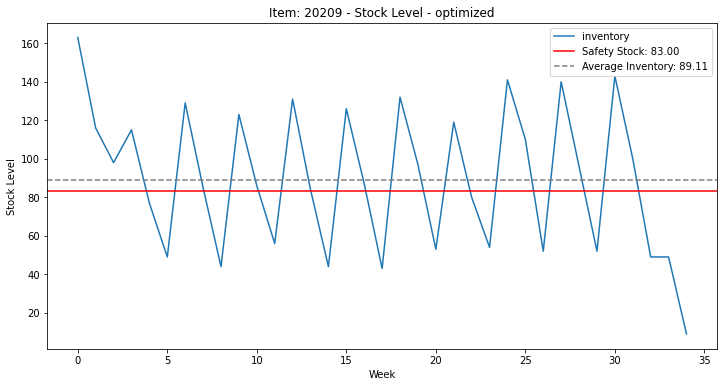

In [100]:
res = smart_replenisher(request_json_20209)
item_id = request_json_20209['item_id']
safety_stock = 83
avg_inventory_level = res['AVG inventory level:']
plt.figure(figsize=(12, 6))
plt.plot(res['exp_inventory_level'], label='inventory')
plt.axhline(y=safety_stock, color='r', linestyle='-', label=f'Safety Stock: {safety_stock:.2f}')
plt.axhline(y=avg_inventory_level, color='grey', linestyle='--', label=f'Average Inventory: {avg_inventory_level:.2f}')
plt.title(f'Item: {item_id} - Stock Level - optimized')
plt.xlabel('Week')
plt.ylabel('Stock Level')
plt.legend()
plt.show()